In [1]:
# Required packages
import pandas as pd
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from cdispyutils.hmac4 import get_auth

In [2]:
# Define functions to use secret keys to get authorization to perform query

auth = ''

def add_keys(filename):
    ''' Get auth from our secret keys '''
    global auth 
    with open(filename,'r') as f:
        secrets = json.load(f)
    auth = get_auth(secrets['access_key'], secrets['secret_key'], 'submission')

add_keys("/home/ubuntu/.secrets")


def query_api(query_txt):
    ''' Request results for a specific query '''
    query = {'query': query_txt}
    output = requests.post('http://kubenode.internal.io:30006/v0/submission/graphql/', auth=auth, json=query).text
    data = json.loads(output) 
    if 'data' not in data and 'errors' in data:
        print query    
    return data

IOError: [Errno 2] No such file or directory: '/home/ubuntu/.secrets'

In [3]:
# GraphQL query that retrieves a list of studies
query = """ {  study(first:0,project_id:"bpa-USC_OPT1_T1", order_by_asc:"submitter_id")  {    study_id: submitter_id  }}"""
data = query_api(query)
data = data["data"]
studies = [ data["study"][i]["study_id"] for i in range(len(data["study"]))  ]

# Gets a list of patients
query = """ {  case(first:0,project_id:"bpa-USC_OPT1_T1", order_by_asc:"submitter_id")  {    patient_id: submitter_id }} """
data = query_api(query)
data = data["data"]
patients = [ data["case"][i]["patient_id"] for i in range(len(data["case"]))   ]

# Create empty dataframe for heatmap with all vlaues set to 0
df = pd.DataFrame(0,columns=studies,index=patients)

# Query to get experiments data for patients (cases)
query = """ {  study(first:0,project_id:"bpa-USC_OPT1_T1", order_by_asc:"submitter_id")  {   study_id: submitter_id   cases(first: 0,order_by_asc:"submitter_id")   {     patient_id: submitter_id   } }}"""
data = query_api(query)
data = data["data"]

# Process returned data so that patients included in each study (experiment) are set to a value of 1, otherwise, leave value at 0
for i in range(len(data["study"])):
    study = data["study"][i]["study_id"]
    for j in range(len(data["study"][i]["cases"])):
        pid = data["study"][i]["cases"][j]["patient_id"]
        df.at[pid,study] = 1 

# Rename dataframe columns to meaningful names
df.columns = ['Rare Cell Enumeration', 'Single-cell IMC', 'Single-cell CNV','Single-cell SNV','cfDNA CNV','cfDNA SNV']


NameError: name 'query_api' is not defined

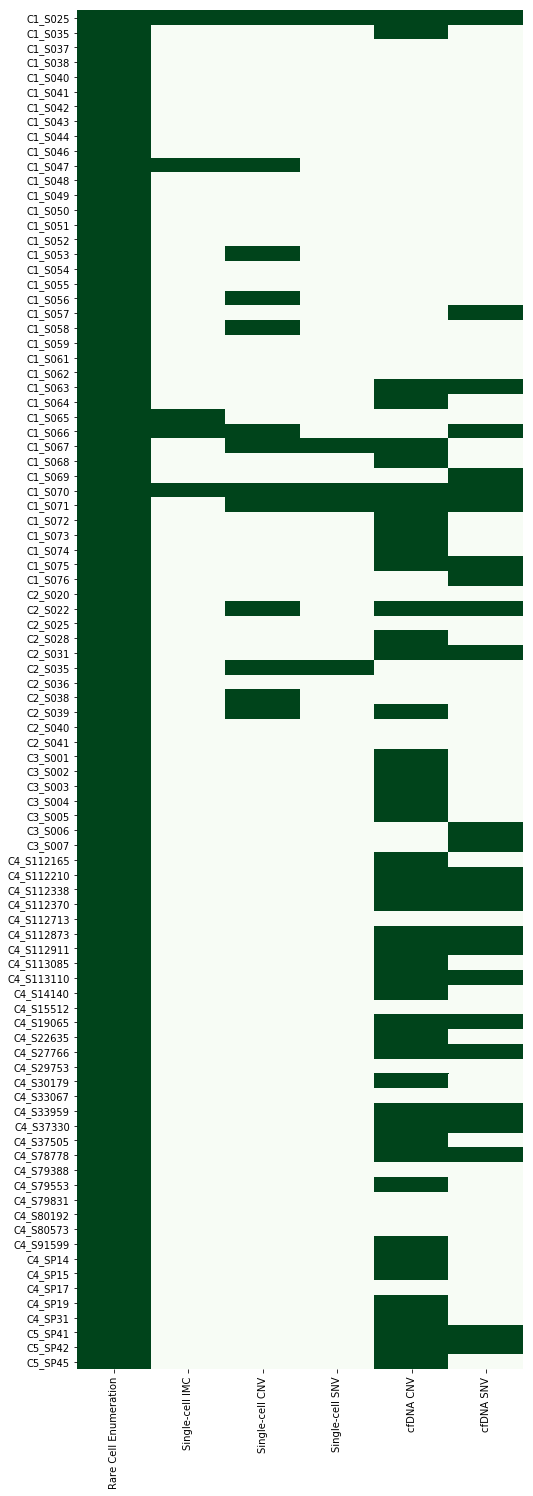

In [5]:
# Plot data returned from query

plt.figure(figsize=(8,25))
pl=sns.heatmap(df,cmap="Greens",cbar=False)

# Uncomment the next two lines and comment the final line to save plot as a PNG image
#plt.switch_backend('agg')
#pl.figure.savefig('USC_Patient_EXPs.png')

plt.show()
